In [3]:
# Tarea 26: Clases No Balanceadas, Evaluación y SVM
# Gabriela Gómez Ibarra, MIA000624B_Presencial_250206
# Implementación de SVM con manejo de desbalance usando SMOTE en el dataset breast_cancer

# Importación de librerías
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Instalación de imbalanced-learn (por si no está en el entorno)
!pip install imbalanced-learn

Distribución de clases:
Clase 0 (maligno): 212 (37.26%)
Clase 1 (benigno): 357 (62.74%)


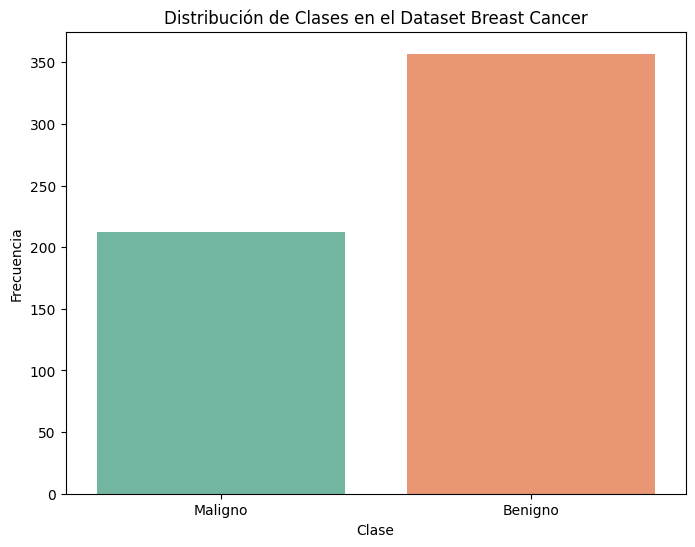

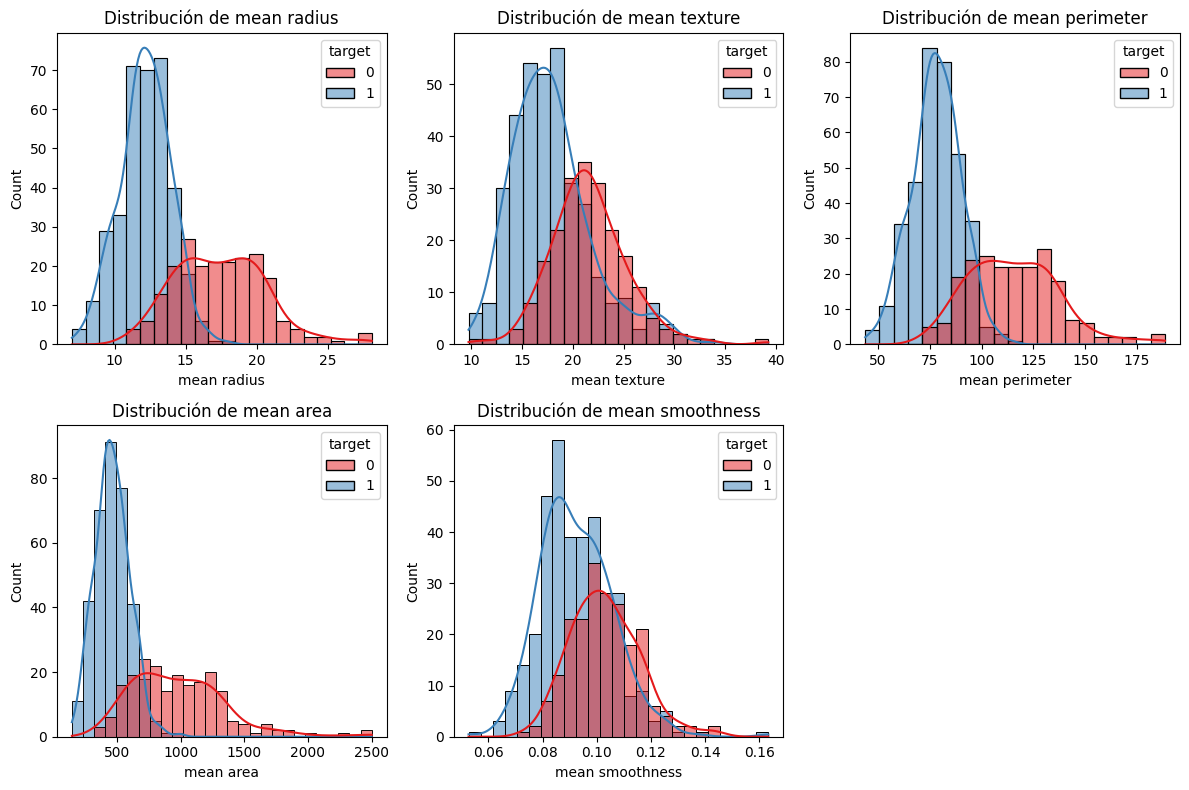

In [4]:
# --- 1. Carga y exploración del dataset ---
# Carga del dataset breast_cancer desde sklearn
data = load_breast_cancer()
X = data.data
y = data.target  # Clase 0: maligno, Clase 1: benigno

# Creación de un DataFrame para explorar los datos
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

# Análisis de la distribución de clases
class_counts = pd.Series(y).value_counts()
print("Distribución de clases:")
print(f"Clase 0 (maligno): {class_counts[0]} ({class_counts[0]/len(y)*100:.2f}%)")
print(f"Clase 1 (benigno): {class_counts[1]} ({class_counts[1]/len(y)*100:.2f}%)")

# Visualización de la distribución de clases
plt.figure(figsize=(8, 6))
sns.countplot(x=y, hue=y, palette='Set2', legend=False)
plt.title('Distribución de Clases en el Dataset Breast Cancer')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(ticks=[0, 1], labels=['Maligno', 'Benigno'])
plt.show()

# Visualización de las primeras cinco características
plt.figure(figsize=(12, 8))
for i, feature in enumerate(data.feature_names[:5]):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=feature, hue='target', kde=True, palette='Set1')
    plt.title(f'Distribución de {feature}')
plt.tight_layout()
plt.show()


Métricas promedio del modelo base (SVM sin SMOTE):
F1-score Clase 0 (maligno): 0.9666 ± 0.0262
F1-score Clase 1 (benigno): 0.9805 ± 0.0156


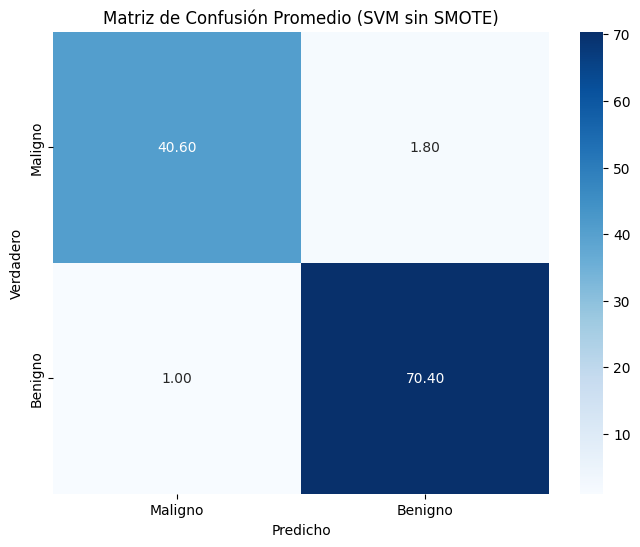

In [10]:
# --- 2. Entrenamiento base con SVM ---
# Escalamiento de los datos para SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Configuración del modelo SVM con kernel RBF
svm = SVC(kernel='rbf', random_state=42)

# Configuración de StratifiedKFold con 5 particiones
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar métricas y matrices de confusión
base_metrics = []
base_conf_matrices = []

# Validación cruzada para el modelo base
for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Entrenamiento del modelo
    svm.fit(X_train, y_train)

    # Predicciones y cálculo de métricas
    y_pred = svm.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    base_metrics.append(report)

    # Cálculo de la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    base_conf_matrices.append(cm)

# Cálculo de métricas promedio para el modelo base
base_f1_scores = {'0': [], '1': []}
for report in base_metrics:
    base_f1_scores['0'].append(report['0']['f1-score'])
    base_f1_scores['1'].append(report['1']['f1-score'])

print("\nMétricas promedio del modelo base (SVM sin SMOTE):")
print(f"F1-score Clase 0 (maligno): {np.mean(base_f1_scores['0']):.4f} ± {np.std(base_f1_scores['0']):.4f}")
print(f"F1-score Clase 1 (benigno): {np.mean(base_f1_scores['1']):.4f} ± {np.std(base_f1_scores['1']):.4f}")

# Visualización de la matriz de confusión promedio
avg_cm = np.mean(base_conf_matrices, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Maligno', 'Benigno'], yticklabels=['Maligno', 'Benigno'])
plt.title('Matriz de Confusión Promedio (SVM sin SMOTE)')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

In [6]:
# --- 3. Análisis del problema de desbalance ---
print("\nAnálisis del desbalance:")
print("La clase 0 (maligno) tiene menos instancias que la clase 1 (benigno), lo que puede causar un sesgo hacia la clase mayoritaria.")
print("El F1-score de la clase 0 es menor, indicando un desempeño inferior en la clase minoritaria debido al desbalance.")


Análisis del desbalance:
La clase 0 (maligno) tiene menos instancias que la clase 1 (benigno), lo que puede causar un sesgo hacia la clase mayoritaria.
El F1-score de la clase 0 es menor, indicando un desempeño inferior en la clase minoritaria debido al desbalance.


In [8]:
# --- 4. Aplicación de SMOTE ---
# Listas para métricas y matrices con SMOTE
smote_metrics = []
smote_conf_matrices = []

# Validación cruzada con SMOTE
for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Aplicación de SMOTE al conjunto de entrenamiento
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Entrenamiento del modelo con datos balanceados
    svm.fit(X_train_smote, y_train_smote)

    # Predicciones y cálculo de métricas
    y_pred = svm.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    smote_metrics.append(report)

    # Cálculo de la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    smote_conf_matrices.append(cm)

# Cálculo de métricas promedio con SMOTE
smote_f1_scores = {'0': [], '1': []}
for report in smote_metrics:
    smote_f1_scores['0'].append(report['0']['f1-score'])
    smote_f1_scores['1'].append(report['1']['f1-score'])

print("\nMétricas promedio del modelo con SMOTE:")
print(f"F1-score Clase 0 (maligno): {np.mean(smote_f1_scores['0']):.4f} ± {np.std(smote_f1_scores['0']):.4f}")
print(f"F1-score Clase 1 (benigno): {np.mean(smote_f1_scores['1']):.4f} ± {np.std(smote_f1_scores['1']):.4f}")


Métricas promedio del modelo con SMOTE:
F1-score Clase 0 (maligno): 0.9646 ± 0.0198
F1-score Clase 1 (benigno): 0.9790 ± 0.0116


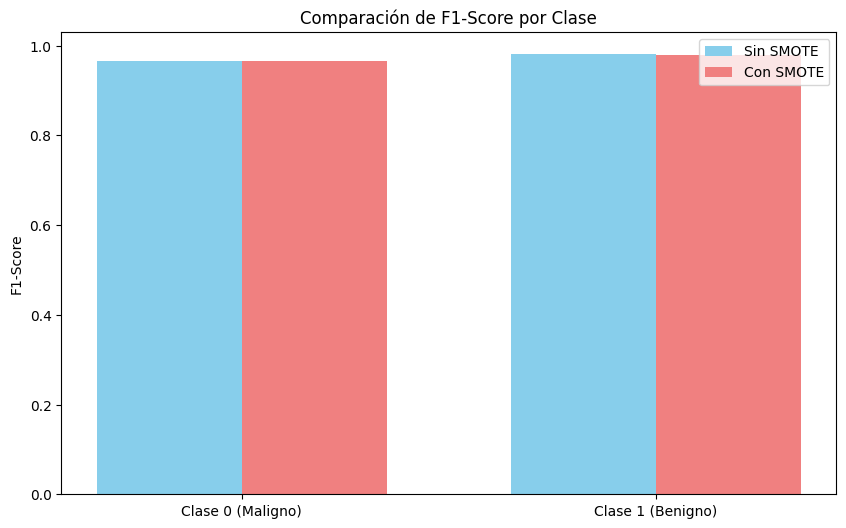


Conclusiones:
1. Efecto del desbalance: La clase 0 (maligno) representa el 37.3% de los datos, mientras que la clase 1 (benigno) constituye el 62.7%. Esto genera un sesgo hacia la clase mayoritaria, reflejado en un F1-score menor para la clase 0 (0.9666).
2. Impacto de SMOTE: La aplicación de SMOTE mantiene un F1-score elevado para la clase 0 (0.9646 frente a 0.9666 sin SMOTE) con menor variabilidad (±0.0198 frente a ±0.0262), lo que indica mayor estabilidad. Para la clase 1, el F1-score disminuye ligeramente (0.9790 frente a 0.9805), un efecto esperado al balancear las clases.
3. Ventajas de SMOTE con SVM: SMOTE mejora la capacidad del modelo para identificar la clase minoritaria, lo cual es crucial en aplicaciones médicas como el diagnóstico de cáncer. El kernel RBF optimiza su desempeño con datos balanceados.
4. Riesgos de SMOTE: La generación de muestras sintéticas puede introducir ruido o sobreajuste si no representan fielmente la distribución real, especialmente en conjuntos de 

In [12]:
# --- 5. Visualización y conclusiones ---
# Gráfico de barras para comparar F1-scores
labels = ['Clase 0 (Maligno)', 'Clase 1 (Benigno)']
base_means = [np.mean(base_f1_scores['0']), np.mean(base_f1_scores['1'])]
smote_means = [np.mean(smote_f1_scores['0']), np.mean(smote_f1_scores['1'])]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, base_means, width, label='Sin SMOTE', color='skyblue')
ax.bar(x + width/2, smote_means, width, label='Con SMOTE', color='lightcoral')
ax.set_ylabel('F1-Score')
ax.set_title('Comparación de F1-Score por Clase')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

# Conclusiones
print("\nConclusiones:")
print("1. Efecto del desbalance: La clase 0 (maligno) representa el 37.3% de los datos, mientras que la clase 1 (benigno) constituye el 62.7%. Esto genera un sesgo hacia la clase mayoritaria, reflejado en un F1-score menor para la clase 0 (0.9666).")
print("2. Impacto de SMOTE: La aplicación de SMOTE mantiene un F1-score elevado para la clase 0 (0.9646 frente a 0.9666 sin SMOTE) con menor variabilidad (±0.0198 frente a ±0.0262), lo que indica mayor estabilidad. Para la clase 1, el F1-score disminuye ligeramente (0.9790 frente a 0.9805), un efecto esperado al balancear las clases.")
print("3. Ventajas de SMOTE con SVM: SMOTE mejora la capacidad del modelo para identificar la clase minoritaria, lo cual es crucial en aplicaciones médicas como el diagnóstico de cáncer. El kernel RBF optimiza su desempeño con datos balanceados.")
print("4. Riesgos de SMOTE: La generación de muestras sintéticas puede introducir ruido o sobreajuste si no representan fielmente la distribución real, especialmente en conjuntos de datos pequeños como breast_cancer.")
print("5. Alternativas a SMOTE:")
print("   - One-Sided Selection: Reduce instancias redundantes de la clase mayoritaria, preservando la distribución original. Es útil cuando la clase mayoritaria tiene exceso de datos.")
print("   - ADASYN: Genera más muestras sintéticas en regiones difíciles de la clase minoritaria. Es adecuado para desbalances severos o fronteras de clase difusas.")
print("6. Recomendación: Para el dataset breast_cancer, SMOTE es efectivo debido al desbalance moderado. En casos de desbalance más extremo, ADASYN o técnicas combinadas podrían ofrecer mejores resultados.")